# Monte Carlo Sampling

This code demonstates basic Monte Carlo sampling methods.

### 1. **Rejection Sampling**
- Draws samples from a **proposal distribution** (Uniform)
- Accepts/rejects based on the target probability distribution
- **Issue**: Wastes many rejected samples

### 2. **Importance Sampling**
- Assigns **weights** to samples from a proposal distribution
- Weighted samples contribute to the estimate
- **Advantage**: More efficient than rejection sampling

### 3. **Markov Chain Monte Carlo (MCMC) - Metropolis-Hastings**
- Generates samples iteratively
- Uses a **proposal move** and **acceptance ratio** to decide movement
- **Advantage**: Efficient in high dimensions

The samples are vizualized and compared by their fit to functional target probability distributions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import entropy

# seed random number generator
np.random.seed(None)

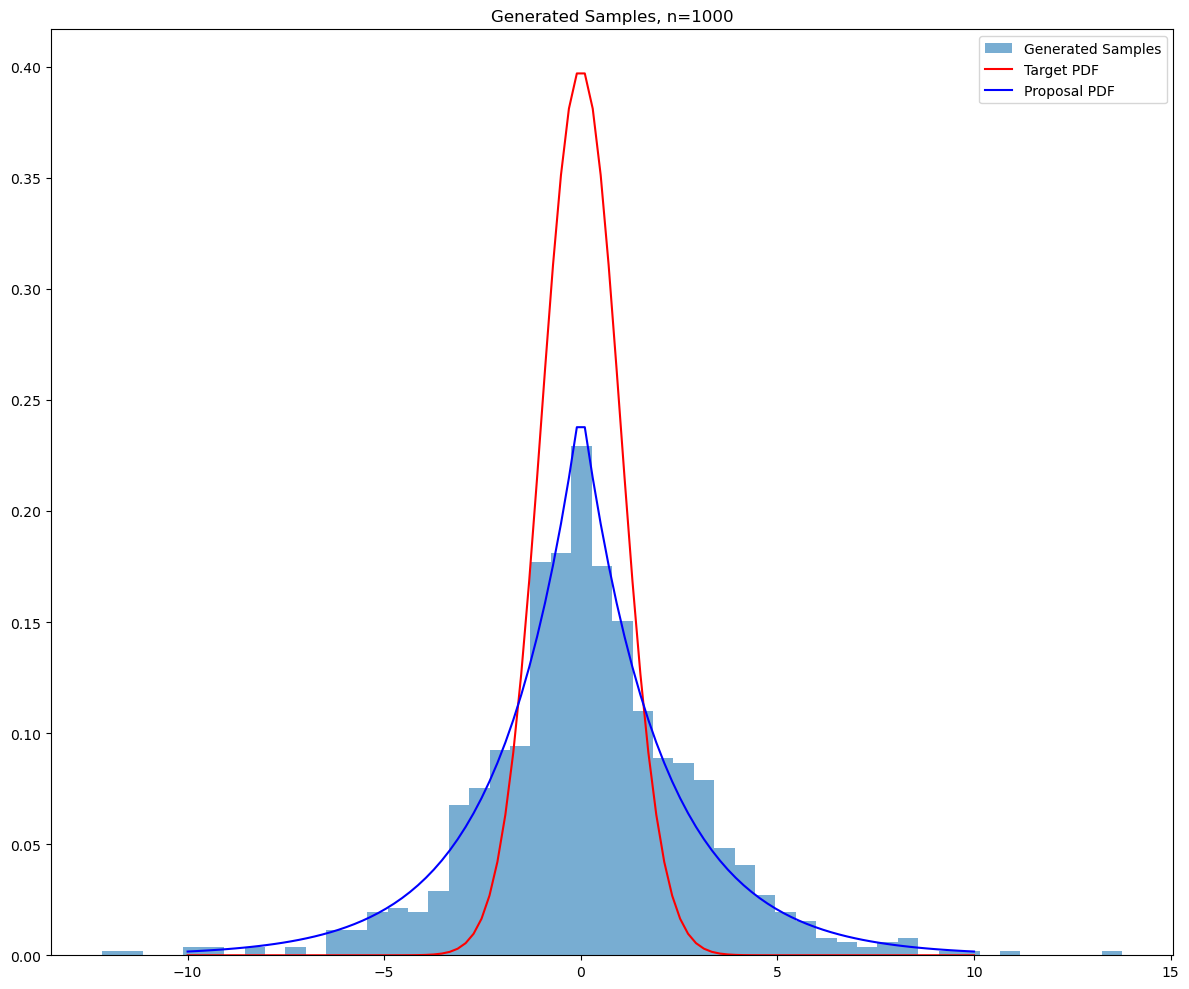

In [2]:
def get_target_proposal(test_case):
    """
    Returns a target distribution and a good proposal distribution for different test cases.
    """
    if test_case == 1:
        target_dist = stats.norm(0, 1)  # Standard Normal
        proposal_dist = stats.norm(0, 2)  # Wider Gaussian
    elif test_case == 2:
        target_dist = stats.norm(0, 1)  # Standard Normal
        proposal_dist = stats.laplace(0, 2)  # Laplace proposal (heavy tails)
    elif test_case == 3:
        target_dist = stats.gamma(a=2, scale=1)  # Gamma target
        proposal_dist = stats.gamma(a=3, scale=1)  # Adjusted Gamma proposal
    elif test_case == 4:
        target_dist = stats.beta(a=2, b=5)  # Beta target
        proposal_dist = stats.beta(a=2, b=4)  # Similar Beta proposal
    elif test_case == 5:
        target_dist = stats.expon(scale=1)  # Exponential target
        proposal_dist = stats.gamma(a=2, scale=1)  # Gamma proposal for better coverage
    else:
        raise ValueError("Invalid test_case. Choose a number between 1 and 5.")
    
    return target_dist, proposal_dist

# Example: Try different test cases
test_case = 2
num_samples = 1000 # Initial number of samples, for rejection sampling
target_dist, proposal_dist = get_target_proposal(test_case)

# X range for plotting the target distribution
x_range = np.linspace(-10, 10, 100)
y_target_range = target_dist.pdf(x_range)

# Generate samples
x_proposal = proposal_dist.rvs(num_samples)
y_target = target_dist.pdf(x_proposal)
y_proposal = proposal_dist.pdf(x_proposal)

# Plot generated samples
plt.figure(figsize=(12, 10))
plt.hist(x_proposal, bins=50, density=True, alpha=0.6, label="Generated Samples")
#plt.hist(np.clip(x_proposal, -3, 3), bins=30, density=True, alpha=0.6, label="Generated Samples (clipped)")
plt.plot(x_range, target_dist.pdf(x_range), 'r-', label="Target PDF")
plt.plot(x_range, proposal_dist.pdf(x_range), 'b-', label="Proposal PDF")
plt.title("Generated Samples, n={}".format(num_samples))
plt.legend()
plt.tight_layout()
plt.show()

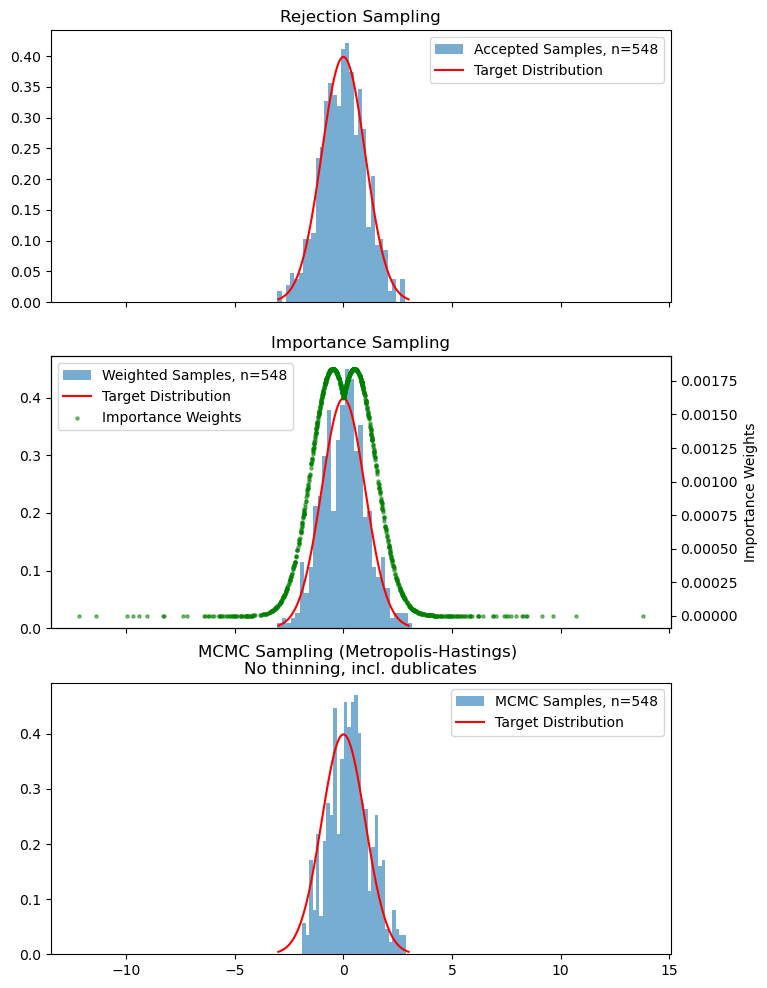

In [3]:
import time
# REJECTION SAMPLING
start_time = time.time()
# Scaling factor to ensure target distribution in bounded from above
M = np.max(y_target / y_proposal) # large M may result in slow sampling
u = np.random.uniform(0, M * y_proposal, num_samples) 
accepted_x = x_proposal[u < y_target]
rejection_time = time.time() - start_time  # Measure execution time
num_final_samples = len(accepted_x)  # Ensuring all methods have the same number of samples

# IMPORTANCE SAMPLING 
start_time = time.time()
weights = y_target / y_proposal
weights /= weights.sum()
importance_x = np.random.choice(x_proposal, size=num_final_samples, p=weights)
importance_time = time.time() - start_time 

# MCMC SAMPLING (METROPOLIS-HASTINGS without thinning)
start_time = time.time()
mcmc_samples = []
current_x = np.random.randn()

#running the chain long enough, eventually yields draws statistically indistinguishable from draws sampled from our target distribution
while len(mcmc_samples) < num_final_samples:  # Ensure equal accepted samples
    proposal_x = current_x + np.random.normal(0, 0.5)

    # Ensure proposal is valid for the target distribution (e.g., Gamma, Beta, Exponential)
    if target_dist.pdf(proposal_x) == 0 or target_dist.pdf(current_x) == 0:
        acceptance_ratio = 0  # Reject immediately if in invalid region
    else:
        # log probabilities for numerical stability
        log_acceptance_ratio = target_dist.logpdf(proposal_x) - target_dist.logpdf(current_x)
        acceptance_ratio = np.exp(min(0, log_acceptance_ratio))  # numerical stability..
        
    if np.random.rand() < acceptance_ratio:
        current_x = proposal_x
    mcmc_samples.append(current_x)  # Only store accepted samples

mcmc_time = time.time() - start_time  # Measure execution time

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Rejection Sampling
axes[0].hist(accepted_x, bins=30, density=True, alpha=0.6, label="Accepted Samples, n={}".format(num_final_samples))
axes[0].plot(np.linspace(-3,3,100), target_dist.pdf(np.linspace(-3,3,100)), 'r-', label="Target Distribution")
axes[0].set_title("Rejection Sampling")
axes[0].legend()

# Importance Sampling
ax1 = axes[1]
hist = ax1.hist(importance_x, bins=30, density=True, alpha=0.6, label="Weighted Samples, n={}".format(num_final_samples))
ax1.plot(np.linspace(-3,3,100), target_dist.pdf(np.linspace(-3,3,100)), 'r-', label="Target Distribution")
ax1.set_title("Importance Sampling")
# Second y-axis for weights
ax2 = ax1.twinx()
scatter = ax2.scatter(x_proposal, weights, color='green', alpha=0.5, s=5, label="Importance Weights")
ax2.set_ylabel('Importance Weights')
# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# MCMC Sampling (Metropolis-Hastings)
axes[2].hist(mcmc_samples, bins=30, density=True, alpha=0.6, label="MCMC Samples, n={}".format(num_final_samples))
axes[2].plot(np.linspace(-3,3,100), target_dist.pdf(np.linspace(-3,3,100)), 'r-', label="Target Distribution")
axes[2].set_title("MCMC Sampling (Metropolis-Hastings) \nNo thinning, incl. dublicates")
axes[2].legend()

In [4]:
def mae(samples, target_dist, bins=30):
    """
    Calculate the Mean Absolute Error (MAE) between the histogram of the samples and the target PDF.
    This measure is less sensitive to outliers.
    """
    hist, bin_edges = np.histogram(samples, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    target_pdf = target_dist.pdf(bin_centers)
    return np.mean(np.abs(hist - target_pdf))

def kl_divergence(samples, target_dist, bins=30):
    """
    Calculate the Kullback-Leibler (KL) divergence between the histogram of the samples and the target PDF.
    """
    hist, bin_edges = np.histogram(samples, bins=bins, density=True)
    hist = hist / np.sum(hist)  # Normalize the histogram
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    target_pdf = target_dist.pdf(bin_centers)
    target_pdf = target_pdf / np.sum(target_pdf)  # Normalize the target PDF
    return entropy(hist, target_pdf)

# Calculate MAE for each sampling method
mae_rejection = mae(accepted_x, target_dist)
mae_importance = mae(importance_x, target_dist)
mae_mcmc = mae(mcmc_samples, target_dist)

# Calculate KL divergence for each sampling method
kl_rejection = kl_divergence(accepted_x, target_dist)
kl_importance = kl_divergence(importance_x, target_dist)
kl_mcmc = kl_divergence(mcmc_samples, target_dist)

# Print the results in a table format
# Print results in table format, including execution times
print(f"{'Method':<25} {'Samples':<10} {'MAE':<15} {'KL Divergence':<15} {'Time (s)':<10}")
print(f"{'-'*80}")
print(f"{'Rejection Sampling':<25} {num_final_samples:<10} {mae_rejection:<15.4f} {kl_rejection:<15.4f} {rejection_time:<10.4f}")
print(f"{'Importance Sampling':<25} {num_final_samples:<10} {mae_importance:<15.4f} {kl_importance:<15.4f} {importance_time:<10.4f}")
print(f"{'MCMC Sampling':<25} {num_final_samples:<10} {mae_mcmc:<15.4f} {kl_mcmc:<15.4f} {mcmc_time:<10.4f}")

Method                    Samples    MAE             KL Divergence   Time (s)  
--------------------------------------------------------------------------------
Rejection Sampling        548        0.0270          0.0297          0.0003    
Importance Sampling       548        0.0321          0.0347          0.0005    
MCMC Sampling             548        0.0627          0.0808          0.0682    
